# Importing the neccessary libraries

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import StandardScaler
import streamlit as st

# Loading the dataset

In [4]:
df = pd.read_csv(r'C:\Users\KIRAN\Downloads\spam.csv', encoding='latin-1')[['v1', 'v2']]

In [ ]:
# Load dataset
df = pd.read_csv(r'C:\Users\KIRAN\Downloads\spam.csv', encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'text']
df['label'] = df['label'].replace({'ham': 0, 'spam': 1})

print("Dataset head:")
print(df.head())

Dataset head:
   label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...

Dataset shape: (5572, 2)


C:\Users\KIRAN\AppData\Local\Temp\ipykernel_12712\4250017808.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['label'].replace({'ham': 0, 'spam': 1})


In [6]:
print("\nDataset shape:", df.shape)


Dataset shape: (5572, 2)


In [7]:
## Explore message content and labels
print("\nMessages by category:")
print(df['label'].value_counts())
print(f"Ham (not suspicious): {df['label'].value_counts()[0]} ({df['label'].value_counts()[0]/len(df)*100:.1f}%)")
print(f"Spam (suspicious): {df['label'].value_counts()[1]} ({df['label'].value_counts()[1]/len(df)*100:.1f}%)")


Messages by category:
label
0    4825
1     747
Name: count, dtype: int64
Ham (not suspicious): 4825 (86.6%)
Spam (suspicious): 747 (13.4%)


# Feature Engineering

In [8]:
## Feature engineering (your original features)
df['text_length'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(x.split()))
df['num_digits'] = df['text'].apply(lambda x: sum(c.isdigit() for c in x))

In [9]:
# Text vectorization (primary features for Naive Bayes)
vectorizer = CountVectorizer(stop_words='english')
X_counts = vectorizer.fit_transform(df['text'])
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

print("\nTF-IDF matrix shape:", X_tfidf.shape)


TF-IDF matrix shape: (5572, 8404)


In [14]:
# Also prepare numeric features (for GNB)
X_numeric = df[['text_length', 'num_words', 'num_digits']]
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# test train spliting

In [15]:
# Split data
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, df['label'], test_size=0.3, random_state=42)
X_train_num, X_test_num, _, _ = train_test_split(X_numeric_scaled, df['label'], test_size=0.3, random_state=42)


# Training all the models

In [16]:
## Train all three Naive Bayes models
models = {
    'GaussianNB': GaussianNB(),
    'MultinomialNB': MultinomialNB(),
    'BernoulliNB': BernoulliNB()
}


GaussianNB Accuracy: 0.9815
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99      1453
        Spam       0.93      0.93      0.93       219

    accuracy                           0.98      1672
   macro avg       0.96      0.96      0.96      1672
weighted avg       0.98      0.98      0.98      1672


MultinomialNB Accuracy: 0.9677
              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98      1453
        Spam       1.00      0.75      0.86       219

    accuracy                           0.97      1672
   macro avg       0.98      0.88      0.92      1672
weighted avg       0.97      0.97      0.97      1672


BernoulliNB Accuracy: 0.9731
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.98      1453
        Spam       0.98      0.81      0.89       219

    accuracy                           0.97      1672
   macro avg       0.98      0.91    

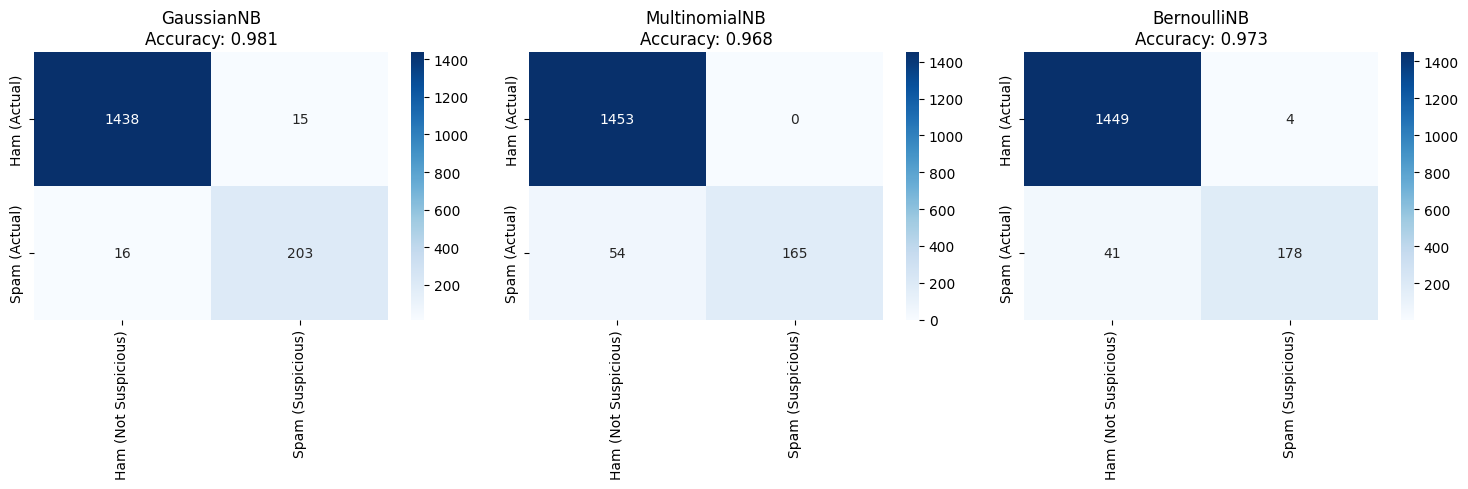

In [17]:
results = {}
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, (name, model) in enumerate(models.items()):
    if name == 'GaussianNB':
        model.fit(X_train_num, y_train)
        y_pred = model.predict(X_test_num)
    else:
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_test_tfidf)
    
    acc = accuracy_score(y_test, y_pred)
    results[name] = {'accuracy': acc, 'predictions': y_pred}
    
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Ham (Not Suspicious)', 'Spam (Suspicious)'],
                yticklabels=['Ham (Actual)', 'Spam (Actual)'])
    axes[idx].set_title(f'{name}\nAccuracy: {acc:.3f}')

plt.tight_layout()
plt.show()

In [19]:
## Analysis: Correct identifications and false flags
print("\n" + "="*50)
print("ANALYSIS:")
print("="*50)
for name, res in results.items():
    cm = confusion_matrix(y_test, res['predictions'])
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n{name}:")
    print(f"• Suspicious messages correctly identified (True Positives): {tp}")
    print(f"• Genuine messages incorrectly flagged (False Positives): {fp}")
    print(f"• Spam precision: {tp/(tp+fp):.3f}")
    print(f"• Ham recall (not flagged correctly): {tn/(tn+fn):.3f}")


ANALYSIS:

GaussianNB:
• Suspicious messages correctly identified (True Positives): 203
• Genuine messages incorrectly flagged (False Positives): 15
• Spam precision: 0.931
• Ham recall (not flagged correctly): 0.989

MultinomialNB:
• Suspicious messages correctly identified (True Positives): 165
• Genuine messages incorrectly flagged (False Positives): 0
• Spam precision: 1.000
• Ham recall (not flagged correctly): 0.964

BernoulliNB:
• Suspicious messages correctly identified (True Positives): 178
• Genuine messages incorrectly flagged (False Positives): 4
• Spam precision: 0.978
• Ham recall (not flagged correctly): 0.972


In [21]:
## Test custom user-entered messages
st.title("🔍 Spam Detector - Test Your Messages")
st.header("Enter message to classify:")

def predict_message(text, models_dict):
    # Vectorize new text
    text_vec = vectorizer.transform([text])
    text_tfidf = tfidf_transformer.transform(text_vec)
    text_num = scaler.transform([[len(text), len(text.split()), sum(c.isdigit() for c in text)]])
    
    predictions = {}
    for name, model in models_dict.items():
        if name == 'GaussianNB':
            pred = model.predict(text_num)[0]
            prob = model.predict_proba(text_num)[0]
        else:
            pred = model.predict(text_tfidf)[0]
            prob = model.predict_proba(text_tfidf)[0]
        predictions[name] = {'label': 'Spam (Suspicious)' if pred == 1 else 'Ham (Not Suspicious)', 
                           'confidence': max(prob)}
    return predictions



print("\nExample tests:")
test_messages = [
    "Hey, free iPhone giveaway! Click now!",
    "Meeting at 3pm tomorrow, see you there.",
    "URGENT: Your account needs verification NOW!"
]

for msg in test_messages:
    print(f"\nMessage: '{msg}'")
    preds = predict_message(msg, models)
    for name, p in preds.items():
        print(f"  {name}: {p['label']} (conf: {p['confidence']:.2f})")

2026-01-21 15:17:02.475 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-21 15:17:02.477 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-21 15:17:02.479 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-21 15:17:02.480 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-21 15:17:02.480 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-21 15:17:02.481 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.



Example tests:

Message: 'Hey, free iPhone giveaway! Click now!'
  GaussianNB: Ham (Not Suspicious) (conf: 1.00)
  MultinomialNB: Ham (Not Suspicious) (conf: 0.84)
  BernoulliNB: Ham (Not Suspicious) (conf: 1.00)

Message: 'Meeting at 3pm tomorrow, see you there.'
  GaussianNB: Ham (Not Suspicious) (conf: 1.00)
  MultinomialNB: Ham (Not Suspicious) (conf: 0.99)
  BernoulliNB: Ham (Not Suspicious) (conf: 1.00)

Message: 'URGENT: Your account needs verification NOW!'
  GaussianNB: Ham (Not Suspicious) (conf: 1.00)
  MultinomialNB: Ham (Not Suspicious) (conf: 0.74)
  BernoulliNB: Ham (Not Suspicious) (conf: 1.00)


c:\Users\KIRAN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\KIRAN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\KIRAN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
